# Knowdge Distillation using Contrastive Learning


 #### Student Name: Emadeddin Rostamian


 #### Student ID: 403206479


In this exercise, we aim to distill knowledge from a large monolingual model into a smaller multilingual model using contrastive learning, specifically leveraging the CLIP model loss.

We employ a small paired English-Persian dataset to define the loss pairs for our CLIP training. Given the substantial dataset size and batch size typically required for CLIP's loss computation (exceeding 19,000 samples per batch in standard tasks), which is impractical for our setup on Colab, we use a reduced batch size to focus on learning the procedure rather than achieving optimal performance, so we don't expect actual real-world results, only the training prcodure.

CLIP (Contrastive Language-Image Pretraining) is a foundational model introduced by OpenAI to bridge the gap between text and image modalities. By aligning text descriptions and corresponding images in a shared embedding space, CLIP achieves remarkable zero-shot generalization capabilities across a wide range of tasks. It is trained on a massive dataset of image-text pairs using contrastive loss, ensuring that image embeddings align closely with their corresponding textual descriptions while remaining distinct from unrelated samples. This cross-modal alignment enables CLIP to perform tasks like image retrieval, captioning, and classification with minimal fine-tuning.

The CLIP loss plays a crucial role in training the model by implementing a cross-entropy loss function in the contrastive learning framework. This loss operates on paired data, where each image-text pair is treated as a positive match, while all other pair combinations in the batch are considered negatives. The loss ensures that positive pairs receive high similarity scores, while negatives are penalized. However, achieving optimal results with CLIP loss often requires large batch sizes to provide sufficient negative samples, which can be computationally intensive. This makes training with limited resources challenging, necessitating adaptations such as smaller batch sizes or alternative strategies to approximate the training dynamics.


Knowledge distillation is a technique used in machine learning to transfer knowledge from a large, complex model (the "teacher") to a smaller, more efficient model (the "student"). The primary goal of this process is to retain the performance and accuracy of the larger model while significantly reducing computational and memory requirements. This is achieved by training the student model to mimic the outputs of the teacher model, often through techniques such as matching soft probability distributions or intermediate representations. Knowledge distillation has become an essential approach in deploying machine learning models on resource-constrained devices such as smartphones and edge devices.

In practice, knowledge distillation is not limited to replicating predictions; it can also involve transferring knowledge about internal features or learned representations.


### Challenges in Resource-Constrained Settings
CLIP’s reliance on large-scale datasets and batch sizes makes direct implementation computationally demanding. This exercise demonstrates an adaptation of the process, reducing batch size and dataset size to provide a practical understanding of the training procedure. While this approach sacrifices performance and real-world applicability, it highlights the mechanics of using CLIP loss for contrastive learning and lays the foundation for extending the process to larger datasets and batch sizes in future applications.



### About CLIP and Contrastive Learning
CLIP, developed by OpenAI, bridges the gap between text and image modalities by aligning corresponding embeddings in a shared space. It leverages contrastive loss to train on image-text pairs, ensuring that embeddings of positive pairs (e.g., an image and its corresponding caption) are highly similar, while embeddings of unrelated pairs remain distinct. The cross-entropy-based contrastive loss evaluates the similarity between positive pairs while penalizing mismatches for all other combinations within a batch.

### Key aspects of CLIP loss include:

- Positive Pairing: Encourages high similarity scores for embeddings of paired text and image data.
- Negative Sampling: Penalizes mismatched pairs within the batch, requiring large batch sizes for effective performance due to the need for a diverse set of negative samples.



## !!! Note !!! You Should Answer to all the TODOs

Also feel free to ask your questions on Quera.



## Setup


We install Required Packages.

In [1]:
!pip install -q gdown
!gdown "https://drive.google.com/uc?id=1MVx_gIkX4tQ8ya2OsHt0mqLmw1Pf2CcK"
!gdown "https://drive.google.com/uc?id=1Co-dwJfWw-C_ral0hoAS_X94wN-_vbCj"

Downloading...
From: https://drive.google.com/uc?id=1MVx_gIkX4tQ8ya2OsHt0mqLmw1Pf2CcK
To: /kaggle/working/train.csv
100%|███████████████████████████████████████| 7.35M/7.35M [00:00<00:00, 122MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Co-dwJfWw-C_ral0hoAS_X94wN-_vbCj
To: /kaggle/working/val.csv
100%|███████████████████████████████████████| 2.45M/2.45M [00:00<00:00, 212MB/s]


In [2]:
!pip install setuptools
import sys
import subprocess
import pkg_resources

def installPackages(packages):
    def installPackage(package):
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

    for package in REQUIRED_PACKAGES:
        try:
            dist = pkg_resources.get_distribution(package)
            print('{} ({}) is installed'.format(dist.key, dist.version))
        except pkg_resources.DistributionNotFound:
            print('{} is NOT installed'.format(package))
            installPackage(package)
            print('{} was successfully installed.'.format(package))

REQUIRED_PACKAGES = [
    'open_clip-torch',
    'pandas',
    'numpy',
    'matplotlib',
    'transformers',
    'tqdm',
    'torch',
    'datasets',
]

installPackages(REQUIRED_PACKAGES)

import gc
import itertools
import re
import math
from collections import Counter
import random
import string
import uuid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import open_clip
from open_clip import model as TE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from datasets import load_dataset, Dataset, Features, Array2D, Value
from transformers import AutoConfig, AutoTokenizer, AutoModel, TFAutoModel

from tqdm import tqdm

<ipython-input-2-16d6a20cb021>:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


open_clip-torch is NOT installed
open_clip-torch was successfully installed.
pandas (2.2.2) is installed
numpy (1.26.4) is installed
matplotlib (3.7.5) is installed
transformers (4.47.0) is installed
tqdm (4.67.1) is installed
torch (2.5.1+cu121) is installed
datasets (3.2.0) is installed


Beware to use cuda for training!

In [3]:
def getDevice(which="cuda:0", yellAtCpu=True):
    if torch.cuda.is_available():
        device = torch.device(which)
    else:
        if yellAtCpu:
             raise Exception("I won't run on CPU!")
        device = torch.device("cpu")

    return device

#### Configs

These are our training configurations, read them!

In [4]:
def Configs():
    return {
        "device": getDevice(),
        "reference_checkPoint" : "EVA02-E-14-plus",                # teacher
        "candidate_checkpoint" : "setu4993/smaller-LaBSE",         # student
        "train_path" : "train.csv",
        "val_path" : "val.csv",
        "save_path" : "./best-model.pth",
        "english" : "en",                                         # dont mind them
        "persian" : "fa",
        "batch_size": 32,                                        # should have been really big, but we can't here
        "lr": 1e-4,
        "epochs": 5,                                               # 40 minute per epoch
        "tok_percentile" : 99,
        "temperature": 20,
        "dropout": 0.05,
        "unfreezed_layers" : 10,
        "weight_decay": 1e-5,
        "patience": 1,
        "factor" : 0.8,
        "reference_embedding": 1024,                               # DONT MIND THESE
        "reference_context_length" : 77,
        "reference_vocab_size" : 49408,
        "reference_heads" : 20,
        "reference_width" : 1280,
        "reference_layers" : 32,
        "cls_token_index" : 0,
        "project_to" : 1024,
    }

configs = Configs()

## Question Box
### TODO (10pts)
1- Why do we use temperature in training using contrastive learning?
<br/>
**Answer:** *To control the scale of similarity scores when computing softmax probabilities. A low-temperature model is stricter meaning it heavily emphasizes the most similar pairs. Meanwhile, a high temperature is more relaxed and doesnt care as much about picking just the top match. It spreads the focus across more pairs, making the model less strict and more forgiving with its similarity scores.* <br/>
2- Why do we need to freeze some layers of a model? mention 2 reasons.
<br/>
**Answer:** *Retain learned features and reduce the computational cost.*<br/>
3- Read the whole code and find out what tok_percentile is used for.<br/>
**Answer:** *To determine a specific token length threshold based on the distribution of token lengths in the dataset. It calculates the token length at the given percentile from the tokenized data. Here tok_percentile is set to 99, so it finds the token length that 99% of the samples are shorter than or equal to. This threshold can then be used to decide things like padding lengths, truncation, or filtering samples that are too long.*

## Data and Preprocessing

In [5]:
def getDatasetsCSV(prevEnCol, prevFaCol, newEnCol, newFaCol, trainPath, valPath):
    df = pd.read_csv(trainPath)
    dfVal = pd.read_csv(valPath)

    if df.empty:
        raise ValueError("Training dataset is empty or missing")

    if dfVal.empty:
        raise ValueError("Validation dataset is empty or missing")

    dfTraind = df.loc[:, [prevEnCol, prevFaCol]].rename(columns={prevEnCol: newEnCol, prevFaCol: newFaCol})
    dfVal = dfVal.loc[:, [prevEnCol, prevFaCol]].rename(columns={prevEnCol: newEnCol, prevFaCol: newFaCol})

    datasetTrain = Dataset.from_pandas(dfTraind)
    datasetVal = Dataset.from_pandas(dfVal)

    return datasetTrain, datasetVal

def getDsByLang(persianCol, englishCol):
    def getPersianDs(dataset):
        return dataset[persianCol]

    def getEnglishDs(dataset):
        return dataset[englishCol]

    getPersianDs.label = persianCol
    getEnglishDs.label = englishCol

    return getPersianDs, getEnglishDs

class Normalizer():
    def __init__(self):
        translation_src = ' ىكي“”0123456789%إأآئيؤةك'
        translation_dst = ' یکی""۰۱۲۳۴۵۶۷۸۹٪اااییوهک'

        self.translations = str.maketrans(translation_src, translation_dst)

        patterns = [
            (r' {2,}', ' '),  # remove extra spaces
            (r'\n+', ' '),  # replace newlines with space
            (r'\u200c+', ' '),  # replace ZWNJs with space
            (r'[ـ\r]', '')  # remove keshide, carriage returns
        ]

        self.character_refinement_patterns = [(re.compile(pattern), repl) for pattern, repl in patterns]

    def normalizeFa(self, text):
        text = text.lower().translate(self.translations)
        text = re.sub('[^a-zA-Z۰-۹آ-ی ]', ' ', text)

        for pattern, repl in self.character_refinement_patterns:
            text = pattern.sub(repl, text)
        return text.strip()

    def normalizeEn(self, text):
        text = text.lower()
        text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
        return text

def applyPreprocess(datasets, configs=configs, Normalizer=Normalizer):
    def applyRowNormalization(example):
        example[configs['persian']] = normalizer.normalizeFa(example[configs['persian']])
        example[configs['english']] = normalizer.normalizeEn(example[configs['english']])

        return example

    normalizer = Normalizer()

    newDatasets = []
    for dataset in datasets:
        newDatasets.append(dataset.map(applyRowNormalization))

    return newDatasets

def preprocessSentence(text, lang, mostFreq=None, Normalizer=Normalizer, configs=configs):
    normalizer = Normalizer()
    if lang == configs['persian']:
        normalized = normalizer.normalizeFa(text)
    elif lang == configs['english']:
        normalized = normalizer.normalizeEn(text)
    else:
        raise ValueError("Not supported lang")

    return normalized

## Utils
### TODO: Complete these Utility functions (10pts)

In [6]:
def getClsToken(tensor, configs=configs):
    """
    Extracts the classification (CLS) token from the input tensor.

    Parameters:
        tensor (torch.Tensor): The input tensor of shape (batch_size, seq_length, hidden_dim).
        configs (dict): A dictionary containing configuration settings. Must include the key "cls_token_index"
                        which specifies the index of the CLS token in the sequence dimension.

    Returns:
        torch.Tensor: A tensor containing the CLS token for each example in the batch,
                      of shape (batch_size, 1, hidden_dim).
    """
    clsId = configs["cls_token_index"]
    return tensor[:, clsId, :]

def flattenMiddle(tensor):
    """
    Flattens the middle dimension (sequence length) of the input tensor, removing it.

    Parameters:
        tensor (torch.Tensor): The input tensor of shape (batch_size, seq_length, hidden_dim).

    Returns:
        torch.Tensor: A tensor of shape (batch_size, hidden_dim) with the middle dimension flattened out.
    """
    return tensor.view(tensor.size(0), -1)

def freezeModel(model):
    """
    Freeze all parameters of a given model.
    Parameters:
        model (torch.nn.Module): The PyTorch model whose parameters are to be frozen.
    """
    for param in model.parameters():
        param.requires_grad = False
    return model

In [7]:
def plotMetric(metricData, metricName):
    if metricName == None or metricName not in metricData:
        raise ValueError("No such metric")
    metricData[metricName].plot()
    plt.xlabel('Epochs')
    plt.ylabel(metricName)
    plt.title(f'Plot of {metricName}')
    plt.show()

threshold=1
def calcPrcentileTokens(dataset, tokenizer, field, percentile=configs["tok_percentile"], thershold=1):
    """
    Calculate the token length at a specific percentile for a dataset field.

    This function tokenizes the data in the specified field of the dataset and calculates
    the token length at the given percentile. An optional threshold can be added to the result.

    Parameters:
        dataset (dict or Dataset): The dataset containing the data to be tokenized.
        tokenizer (callable): A tokenizer function or object with a callable interface
                              (e.g., HuggingFace tokenizer).
        field (str): The field in the dataset whose token lengths are to be calculated.
        percentile (float, optional): The percentile to compute (default is the value in
                                       `configs["tok_percentile"]`).
        thershold (int, optional): A value to add to the calculated percentile token length
                                    (default is 1).

    Returns:
        int: The token length at the specified percentile plus the threshold.

    Raises:
        KeyError: If the specified field does not exist in the dataset.
        TypeError: If `tokenized` is not in the expected format.

    Example:
        dataset = {"text": ["This is a sentence.", "Another example sentence."]}
        tokenizer = lambda x: {"input_ids": [[1, 2, 3, 4], [5, 6, 7, 8, 9]]}
        field = "text"
        calcPrcentileTokens(dataset, tokenizer, field, percentile=95, thershold=2)

    Notes:
        - If the tokenized output is a dictionary (e.g., HuggingFace tokenizers), it assumes
          that `input_ids` contains the token sequences.
        - If the tokenized output is a tensor, nonzero token counts are used to determine lengths.
    """
    tokenized = tokenizer(dataset[field])
    if not isinstance(tokenized, torch.Tensor):
        tokenLengths = list(map(lambda sen: len(sen), tokenized['input_ids']))
    else:
        tokenLengths = [tensor.nonzero().size(0) for tensor in tokenized]
    percentileLength = np.percentile(tokenLengths, percentile)
    return int(percentileLength) + 1

# Dont Touch This
def TextEncoder(configs):
    newModel = TE.TextTransformer(context_length=configs['reference_context_length'],
                                 vocab_size=configs["reference_vocab_size"],
                                 width=configs["reference_width"],
                                 layers=configs["reference_layers"],
                                 heads=configs["reference_heads"],
                                 output_dim=configs["reference_embedding"])
    return newModel


## Models

### TODO: Compelete the Swish and LinearProjection functions based on the pydoc provided (15pts)

In [8]:
class Swish(nn.Module):
    """
    Implements the Swish activation function.
    Parameters:
        beta (float, optional): The scaling parameter for the input x in the sigmoid
                                function. Default is 1.0.
    """
    def __init__(self, beta=1.0):
        super().__init__()
        self.beta = beta

    def forward(self, x):
        return x * torch.sigmoid(self.beta * x)


class LinearProjection(nn.Module):
    """
    A projection layer with Swish activation, batch normalization, dropout, and residual connections.

    This module takes an input tensor, applies a series of transformations, and produces an
    output tensor of the same shape, making use of residual connections and layer normalization.

    Parameters:
        embedding_dim (int): The dimensionality of the input embeddings.
        projection_dim (int, optional): The dimensionality of the projection. Default is
                                        `configs['project_to']`.
        dropout (float, optional): The dropout rate. Default is `configs['dropout']`.

    Layers:
        - projection: Linear layer that projects the input to the specified `projection_dim`.
        - swish: Swish activation function with a fixed beta of 1.0.
        - batch_norm: Batch normalization applied after projection.
        - fc: Fully connected layer for further transformations.
        - dropout: Dropout applied to the output of the fully connected layer.
        - layer_norm: Layer normalization applied after residual connection.

    Methods:
        forward(x):
            Applies the projection, activation, normalization, dropout, residual connection,
            and layer normalization to the input tensor.

    Example:
        model = LinearProjection(embedding_dim=128, projection_dim=64, dropout=0.1)
        output = model(input_tensor)
    """
    def __init__(self, embedding_dim, projection_dim=configs['project_to'], dropout=configs['dropout']):
        super(LinearProjection, self).__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.swish = Swish(beta=1.0)
        self.batch_norm = nn.BatchNorm1d(projection_dim)
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        proj = self.projection(x)
        proj = self.swish(proj)
        proj = self.batch_norm(proj)
        out = self.fc(proj)
        out = self.dropout(out)
        out = self.layer_norm(out + proj)
        return out

In [9]:
class CandidateModel(nn.Module):
    def __init__(self, model_name, unfreezeLayers, trainable=True):
        super().__init__()
        self.candidateProjection = LinearProjection(embedding_dim=configs["candidate_embedding"])
        self.configs = AutoConfig.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.batchNorm = nn.BatchNorm1d(configs["candidate_embedding"])
        self.targetTokenIdx = configs["cls_token_index"]

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        clsEmbed = getClsToken(output.last_hidden_state)
        clsEmbed = self.batchNorm(clsEmbed)
        clsEmbed = self.candidateProjection(flattenMiddle(clsEmbed))
        return clsEmbed

## Training

### TODO: Compelete the calcLoss functions based on the pydoc provided (20pts)

In [10]:
def calcLoss(batch, referenceModel, candidateModel, temperature):
    """
    Compute the loss and the number of correct predictions for a contrastive learning task.

    This function calculates a symmetric cross-entropy loss between the embeddings
    generated by a reference model and a candidate model. It also computes the
    number of correct predictions based on the alignment of the embeddings.

    Args:
        batch (dict): A batch of data containing:
            - "candidate" (torch.Tensor): Tokenized input for the candidate model.
            - "reference" (torch.Tensor): Tokenized input for the reference model.
        referenceModel (nn.Module): The model generating embeddings for the reference input.
        candidateModel (nn.Module): The model generating embeddings for the candidate input.
        temperature (float): A scaling factor to control the logits' sharpness during similarity calculation.

    Returns:
        tuple:
            - loss (torch.Tensor): The computed symmetric cross-entropy loss.
            - corrects (int): The number of correctly predicted alignments.

    Notes:
        - The embeddings are normalized to ensure their magnitudes do not impact similarity.
        - Logits represent scaled cosine similarity between reference and candidate embeddings.
        - The targets are identity matrices, assuming perfect alignment between reference and candidate inputs.

    Example Usage:
        batch = {
            "candidate": tokenized_candidate,
            "reference": tokenized_reference
        }
        loss, corrects = calcLoss(batch, reference_model, candidate_model, temperature=0.1)
    """
    # Move tokenized inputs to the specified device
    candidateTokenized = batch["candidate"].to(configs["device"])
    referenceTokenized = batch["reference"].to(configs["device"])

    # Generate embeddings from reference and candidate models
    referenceEmbeds = referenceModel(referenceTokenized)
    candidateEmbeds = candidateModel(
        input_ids=candidateTokenized["input_ids"],
        attention_mask=candidateTokenized["attention_mask"]
    )

    # Normalize embeddings to have unit length
    referenceEmbeds = F.normalize(referenceEmbeds, p=2, dim=-1)
    candidateEmbeds = F.normalize(candidateEmbeds, p=2, dim=-1)
        #TODO
    logits = torch.matmul(referenceEmbeds, candidateEmbeds.T) / temperature
    labels = torch.arange(logits.size(0)).to(configs["device"])

    loss = F.cross_entropy(logits, labels) + F.cross_entropy(logits.T, labels)
    corrects = (logits.argmax(dim=-1) == labels).sum().item()

    return loss, corrects


### TODO: Fill the trainLoop and valLoop (5pts)

In [11]:
def trainLoop(dataloader, models, referenceTokenizer, candidateTokenizer, optimizer, temperature):
    models['candidateModel'].train()

    totalLoss = 0.0
    totalCorrects = 0
    print("Training Starts!")
    for (index, pairs) in tqdm(enumerate(dataloader), total=len(dataloader)):

        candidteTokenized = candidateTokenizer(getPersianDs(pairs), padding='max_length', truncation=True, return_tensors="pt", max_length=configs["fa_tok_percentile"])
        referenceTextTokenized = referenceTokenizer(getEnglishDs(pairs))

        batch = {
            "candidate" : candidteTokenized,
            "reference" : referenceTextTokenized
        }

        optimizer.zero_grad()
        loss, corrects = calcLoss(batch, models['referenceModel'], models['candidateModel'], temperature)
        loss.backward()
        optimizer.step()

        totalLoss += loss
        totalCorrects += corrects

    avgLoss = totalLoss / len(dataloader.dataset)
    avgAccuracy = totalCorrects / len(dataloader.dataset)

    print("train loss", avgLoss.to("cpu").item())
    print("train accuracy", avgAccuracy)

    return avgLoss, avgAccuracy

def valLoop(dataloader, models, referenceTokenizer, candidateTokenizer, temperature):
    models['candidateModel'].eval()

    totalLoss = 0.0
    totalCorrects = 0

    with torch.no_grad():
        for (index, pairs) in tqdm(enumerate(dataloader), total=len(dataloader)):
            candidteTokenized = candidateTokenizer(getPersianDs(pairs), padding='max_length', truncation=True, return_tensors="pt", max_length=configs["fa_tok_percentile"])
            referenceTextTokenized = referenceTokenizer(getEnglishDs(pairs))

            batch = {
                "candidate" : candidteTokenized,
                "reference" : referenceTextTokenized
            }

            loss, corrects = calcLoss(batch, models['referenceModel'], models['candidateModel'], temperature)

            totalLoss += loss
            totalCorrects += corrects

    avgLoss = totalLoss / len(dataloader.dataset)
    avgAccuracy = totalCorrects / len(dataloader.dataset)

    print("test loss", avgLoss.to("cpu").item())
    print("test accuracy", avgAccuracy)

    return avgLoss, avgAccuracy

In [12]:
oldCols = ["en", "fa"]
datasetTrain, datasetVal = getDatasetsCSV(oldCols[0], oldCols[1], configs["english"], configs["persian"], configs["train_path"], configs["val_path"])

getPersianDs, getEnglishDs = getDsByLang(configs["persian"], configs["english"])
print("Before Preproccess: ", datasetTrain[0])
datasetTrain, datasetVal = applyPreprocess([datasetTrain, datasetVal], configs)
print("After Preproccess: ", datasetTrain[0])
trainDataloader = DataLoader(datasetTrain, batch_size=configs['batch_size'], shuffle=True)
valDataloader = DataLoader(datasetVal, batch_size=configs['batch_size'], shuffle=False)

Before Preproccess:  {'en': 'A person doing karate in a green business card.', 'fa': 'شخصی که کاراته انجام می دهد در کارت ویزیت سبز.'}


Map:   0%|          | 0/59999 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

After Preproccess:  {'en': 'a person doing karate in a green business card', 'fa': 'شخصی که کاراته انجام می دهد در کارت ویزیت سبز'}


#### Tokenizers

In [13]:
referenceTokenizer = open_clip.get_tokenizer(configs["reference_checkPoint"])

candidateConfig = AutoConfig.from_pretrained(configs["candidate_checkpoint"])
candidateTokenizer = AutoTokenizer.from_pretrained(configs["candidate_checkpoint"])

configs = configs | {"candidate_embedding" : candidateConfig.hidden_size}

faTokenPercentile = calcPrcentileTokens(datasetTrain, candidateTokenizer, configs["persian"])
faTokenPercentile

enTokenPercentile = calcPrcentileTokens(datasetTrain, referenceTokenizer, configs["english"])
enTokenPercentile

configs = configs | {"en_tok_percentile" : enTokenPercentile}
configs = configs | {"fa_tok_percentile" : faTokenPercentile}

config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/367 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.47M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

#### Models

In [14]:
referenceModel = TextEncoder(configs).to(configs["device"])
candidateModel = CandidateModel(model_name=configs["candidate_checkpoint"], unfreezeLayers=configs["unfreezed_layers"]).to(configs["device"])
referenceModel = freezeModel(referenceModel)

candidateModel.to(configs['device'])
referenceModel.to(configs['device'])

models = {
    "referenceModel" : referenceModel,
    "candidateModel" : candidateModel
}

model.safetensors:   0%|          | 0.00/877M [00:00<?, ?B/s]

## Training
### TODO (10pts) for running the code and (20pts) for achieving above 70 percent test accuracy

In [15]:
temperature = torch.nn.Parameter(torch.tensor(configs['temperature']).float())
optimizer = torch.optim.AdamW(list(models['candidateModel'].parameters()) + [temperature], weight_decay=configs["weight_decay"], lr=configs['lr'])
lrScheduler = ReduceLROnPlateau(optimizer, 'max', patience=configs['patience'], factor=configs['factor'])


In [16]:

bestValAcc = float('-inf')

metrics = pd.DataFrame(columns=["Avg-train-loss", "Avg-train-accuracy","Avg-val-loss", "Avg-val-accuracy"])

for t in range(configs['epochs']):
    trainLoss, trainAcc = trainLoop(trainDataloader, models, referenceTokenizer, candidateTokenizer, optimizer, temperature)
    valLoss, valAcc = valLoop(valDataloader, models, referenceTokenizer, candidateTokenizer, temperature)

    metrics.loc[t+1] = [trainLoss.item(), trainAcc, valLoss.item(), valAcc]

    lrScheduler.step(valAcc)

    print("Temperature at this epoch was :", temperature.item())

print(f'Best accuracy of validation gained: ', bestValAcc)
print("Done!")

Training Starts!


100%|██████████| 1875/1875 [23:12<00:00,  1.35it/s]


train loss 0.215844064950943
train accuracy 0.6364939415656927


100%|██████████| 625/625 [06:40<00:00,  1.56it/s]


test loss 0.21573427319526672
test accuracy 0.79865
Temperature at this epoch was : 19.793445587158203
Training Starts!


100%|██████████| 1875/1875 [23:13<00:00,  1.35it/s]


train loss 0.21570105850696564
train accuracy 0.8257804296738279


100%|██████████| 625/625 [06:40<00:00,  1.56it/s]


test loss 0.21566513180732727
test accuracy 0.8754
Temperature at this epoch was : 19.595184326171875
Training Starts!


100%|██████████| 1875/1875 [23:14<00:00,  1.34it/s]


train loss 0.2156335562467575
train accuracy 0.887181453024217


100%|██████████| 625/625 [06:41<00:00,  1.56it/s]


test loss 0.2156165987253189
test accuracy 0.89855
Temperature at this epoch was : 19.400524139404297
Training Starts!


100%|██████████| 1875/1875 [23:15<00:00,  1.34it/s]


train loss 0.21558451652526855
train accuracy 0.9168652810880181


100%|██████████| 625/625 [06:41<00:00,  1.56it/s]


test loss 0.21558494865894318
test accuracy 0.909
Temperature at this epoch was : 19.20743751525879
Training Starts!


100%|██████████| 1875/1875 [23:16<00:00,  1.34it/s]


train loss 0.21554850041866302
train accuracy 0.9349822497041618


100%|██████████| 625/625 [06:42<00:00,  1.55it/s]

test loss 0.21558070182800293
test accuracy 0.8971
Temperature at this epoch was : 19.015867233276367
Best accuracy of validation gained:  -inf
Done!


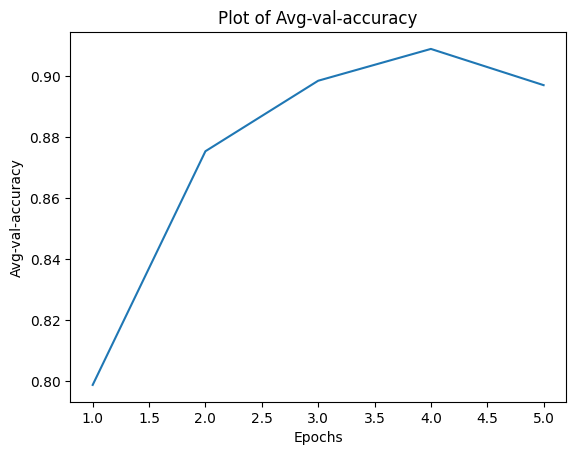

,Avg-train-loss,Avg-train-accuracy,Avg-val-loss,Avg-val-accuracy
3,0.215634,0.887181,0.215617,0.89855
4,0.215585,0.916865,0.215585,0.90900
5,0.215549,0.934982,0.215581,0.89710


In [17]:
plotMetric(metrics, "Avg-val-accuracy")
metrics.tail(3)

## Question Box (10pts + 5pts bonus)

1- Do we even need normalization for tasks like this? will they provide any accuracy gain? write what you think.
<br/>
**Answer:** *Yes, normalization is necessary for contrastive learning tasks like this since it keeps embeddings focused on their direction instead of size. It doesn’t guarantee better accuracy but makes training smoother and less chaotic, especially with cosine similarity.* <br/>
2- When training a neural network, what takes the memory? mention at least 4 things.
<br/> **Answer:** <br/>
    *1. Model parameters: Memory is used to store weights and biases of the model*<br/>
    *2. Intermediate activations: Forward-pass computations store activations needed for the backward pass*<br/>
    *3. Gradients: During backpropagation, gradients of all parameters are stored for weight updates*<br/>
    *4. Batch size: Memory scales linearly with batch size as data for all samples in the batch is processed simultaneously*<br/>
3- find out the actual Open Ai's training configuration of Clip model.
**Answer:** *OpenAI trained CLIP on 400 million image-text pairs, with a large batch size of 32,768 to maximize negative samples for contrastive learning. They used a combination of ResNet and Vision Transformer (ViT) architectures with embedding dimensions ranging from 512 to 1024. Training utilized distributed GPUs, mixed precision for efficiency, and cosine learning rate scheduling.*


#### Bonus
4- We have an alternative clip's loss implementation, write its pseudocode. <br/>
**Triplet CLIP Loss with Hard Negative Mining:**

In [18]:
def triplet_clip_loss(image_embeddings, text_embeddings, margin=0.2):
    """
    Computes an alternative CLIP loss using triplet loss with hard negative mining.

    Args:
        image_embeddings: Normalized embeddings for images (batch_size, embedding_dim).
        text_embeddings: Normalized embeddings for text (batch_size, embedding_dim).
        margin: Margin for triplet loss (default 0.2).

    Returns:
        loss: The computed triplet loss.
    """
    # Normalize embeddings
    image_embeddings = normalize(image_embeddings, dim=-1)
    text_embeddings = normalize(text_embeddings, dim=-1)

    # Compute pairwise similarity (cosine similarity)
    similarity_matrix = matmul(image_embeddings, text_embeddings.T)

    # Get positive pairs (diagonal of the similarity matrix)
    positive_similarity = diag(similarity_matrix)

    # Compute hardest negatives
    hardest_image_negative = max(similarity_matrix, dim=1).values  # Max similarity for each image row
    hardest_text_negative = max(similarity_matrix, dim=0).values  # Max similarity for each text column

    # Compute triplet loss for images
    image_loss = relu(margin + hardest_image_negative - positive_similarity)

    # Compute triplet loss for text
    text_loss = relu(margin + hardest_text_negative - positive_similarity)

    # Combine losses
    loss = (image_loss.mean() + text_loss.mean()) / 2
    return loss
